In [1]:
from collections import OrderedDict
import copy
import numpy as np
import matplotlib.pyplot as plt
import os
import scipy.optimize as spopt
import platereaderdataloader as prdl

%matplotlib inline

In [2]:
cd "Experiment 1"

/home/kuhlmanlab/Documents/Long Term Evolution Experiments/Experiment 1


In [3]:
days = OrderedDict()

filename_end = ' July 2018 NS001 delta CAT 30 C.xlsx'
platelayout1 = ['0,0,'+str(i) for i in range(1,10)] + ['50,0,'+str(i) for i in range(1,10)] + \
               ['2000,0,'+str(i) for i in range(1,10)] + ['2000,2,'+str(i) for i in range(1,10)] + \
               ['2000,10,'+str(i) for i in range(1,10)] + ['blank1', 'blank2', 'blank3']
platelayout2 = ['2000,0,'+str(i) for i in range(1,10)] + ['2000,2,'+str(i) for i in range(1,10)] + \
               ['2000,10,'+str(i) for i in range(1,10)]  + ['50,0,'+str(i) for i in range(1,10)] + \
               ['0,0,'+str(i) for i in range(1,10)] + ['blank1', 'blank2', 'blank3']

for i in range(9,10):
    filename = str(i) + filename_end
    platelayout180 = copy.copy(platelayout1)
    platelayout180.reverse()
    days[i-9] = prdl.import_platereader(filename, platelayout180)

#for i in range(10,20)
for i in range(10,19):
    filename = str(i) + filename_end
    days[i-9] = prdl.import_platereader(filename,platelayout1)
    
#for i in range(20,27):
    #filename = str(i) + filename_end
    #days[i] = prdl.import_platereader(filename,platelayout2)'''

In [4]:
cd ..

/home/kuhlmanlab/Documents/Long Term Evolution Experiments


In [5]:
cd "Experiment 1 Branch off July 18"

/home/kuhlmanlab/Documents/Long Term Evolution Experiments/Experiment 1 Branch off July 18


In [6]:
# days_branch = OrderedDict()

filename_end_branch = ' 2018 NS001 delta CAT mutation rate titrations.xlsx'

platelayout_branch = platelayout1

treatments = copy.deepcopy(platelayout_branch)
treatments.remove('blank1')
treatments.remove('blank2')
treatments.remove('blank3')
        
for i in range(0,8):
    filename = str(i+24) + ' August' + filename_end_branch
    days[i+10]=prdl.import_platereader(filename, platelayout_branch)
    #days_branch[i]=prdl.import_platereader(filename, platelayout_branch)

for i in range(8,17):
    filename = str(i-7) + ' September' + filename_end_branch
    days[i+10]=prdl.import_platereader(filename, platelayout_branch)
    #days_branch[i]=prdl.import_platereader(filename, platelayout_branch)

In [7]:
cd ..

/home/kuhlmanlab/Documents/Long Term Evolution Experiments


In [8]:
cd "Experiment 1 Branch 1 Continued 28 Sept"

/home/kuhlmanlab/Documents/Long Term Evolution Experiments/Experiment 1 Branch 1 Continued 28 Sept


In [9]:
#days_continue = OrderedDict()

filename_end_continue = ' 2018 NS001 delta CAT mutation rate titrations.xlsx'
        
for i in range(0,4):
    filename = str(i+27) + ' September' + filename_end_branch
    days[i+27]=prdl.import_platereader(filename, platelayout_branch)
    #days_continue[i]=prdl.import_platereader(filename, platelayout_branch)

for i in range(4,15):
    filename = str(i-3) + ' October' + filename_end_branch
    days[i+27] = prdl.import_platereader(filename, platelayout_branch)
    #days_continue[i]=prdl.import_platereader(filename, platelayout_branch)

In [10]:
def shifted_exp(t, P0, r, C):
    return P0*np.exp(r*t)+C

def exp(t, P0, r):
    return P0*np.exp(r*t)

def estimate_blank(data):
    blanks = []
    for key in data:
        b1 = np.mean(data[key]['well_ODs']['blank1'])
        b2 = np.mean(data[key]['well_ODs']['blank2'])
        b3 = np.mean(data[key]['well_ODs']['blank3'])
        blanks.append(np.median(np.array([b1,b2,b3])))
    return np.median(np.array(blanks))

def fit_phases(t, P, cut_below, cut_above, blank=None):
    try:
        i1 = np.where(P<cut_below)[0][0]+1
    except IndexError:
        i1 = 0
    i2 = np.where(P>cut_above)[0][0]
    try:
        if blank is None:
            bounds = (np.array([0, 0, 0]), np.array([np.inf, np.inf, np.inf]))
            popt_exp, pcov_exp = spopt.curve_fit(shifted_exp, t[i1:i2], P[i1:i2], p0=(.002, 1, .08), bounds=bounds)
        else:
            bounds = (np.array([0, 0, blank]), np.array([np.inf, np.inf, blank+.0000001]))
            popt_exp, pcov_exp = spopt.curve_fit(shifted_exp, t[i1:i2], P[i1:i2], p0=(.002, 1, blank), bounds=bounds)
    except RuntimeError:
        popt_exp = np.ones(3)*np.nan
        pcov_exp = np.ones((3,3))*np.nan
    stat_index = np.where(P>.4)[0][0]
    try:
        popt_sta, pcov_sta = spopt.curve_fit(shifted_exp, t[stat_index:], P[stat_index:], p0=(-.1, -.2, .5))
    except RuntimeError:
        popt_sta = np.ones(3)*np.nan
        pcov_sta = np.ones(3)*np.nan
    K_est = np.mean(np.sort(P)[-10:])
    return popt_exp, pcov_exp, popt_sta, pcov_sta, K_est

def fit_over_experiments(data, days, samples, cut_below=.125, cut_above=.24, blank=None):
    popt_exp = OrderedDict()
    pcov_exp = OrderedDict()
    popt_sta = OrderedDict()
    pcov_sta = OrderedDict()
    experiment_days = len(days)
    if blank is not None:
        blank = estimate_blank(data)
    for sample in samples:
        popt_exp[sample]=np.zeros((3,experiment_days))
        pcov_exp[sample]=np.zeros((3,3,experiment_days))
        popt_sta[sample]=np.zeros((3,experiment_days))
        pcov_sta[sample]=np.zeros((3,3,experiment_days))
        for i in range(experiment_days):
            t = data[days[i]]['times']
            P = data[days[i]]['well_ODs'][sample]
            pexp, covexp, psta, covsta, K = fit_phases(t, P, cut_below, cut_above, blank=blank)
            popt_exp[sample][:,i] = pexp
            pcov_exp[sample][:,:,i] = covexp
            popt_sta[sample][:,i] = psta
            pcov_sta[sample][:,:,i] = covsta
    return popt_exp, pcov_exp, popt_sta, pcov_sta, blank

In [11]:
pexps, covexps, pstas, covstas, blank = fit_over_experiments(days, range(42), treatments, blank=1)

/home/kuhlmanlab/anaconda3/lib/python3.6/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


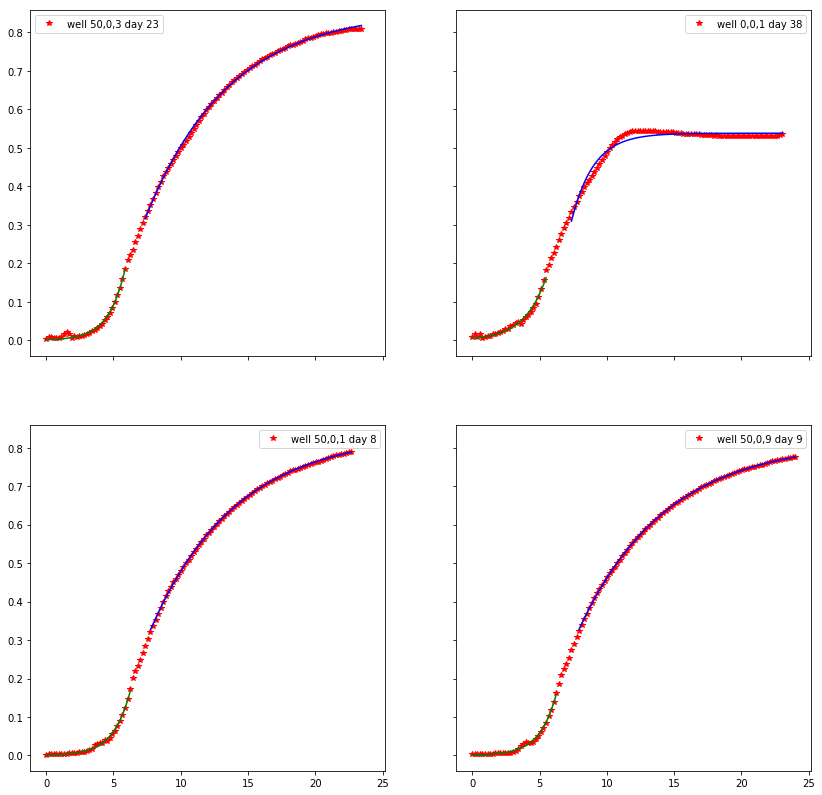

In [12]:
rows = 2
columns = 2
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(14,14))
for i in range(rows):
    for j in range(columns):
        day = np.random.randint(42)
        well = treatments[np.random.randint(45)]
        t = days[day]['times']
        P = days[day]['well_ODs'][well]
        cut_index = np.where(P>.24)[0][0]
        p0 = pexps[well][0][day]
        r = pexps[well][1][day]
        exp_fit = shifted_exp(t[:cut_index+1], p0, r, blank)
        stat_index = np.where(P>.4)[0][0]
        stat_fit = shifted_exp(t[stat_index:], *pstas[well][:,day])
        axes[i,j].plot(t, P-blank, 'r*', label='well ' + well + ' day ' + str(day))
        axes[i,j].plot(t[:cut_index+1], exp_fit-blank, 'g-')
        axes[i,j].plot(t[stat_index:], stat_fit-blank, 'b-')
        axes[i,j].legend()

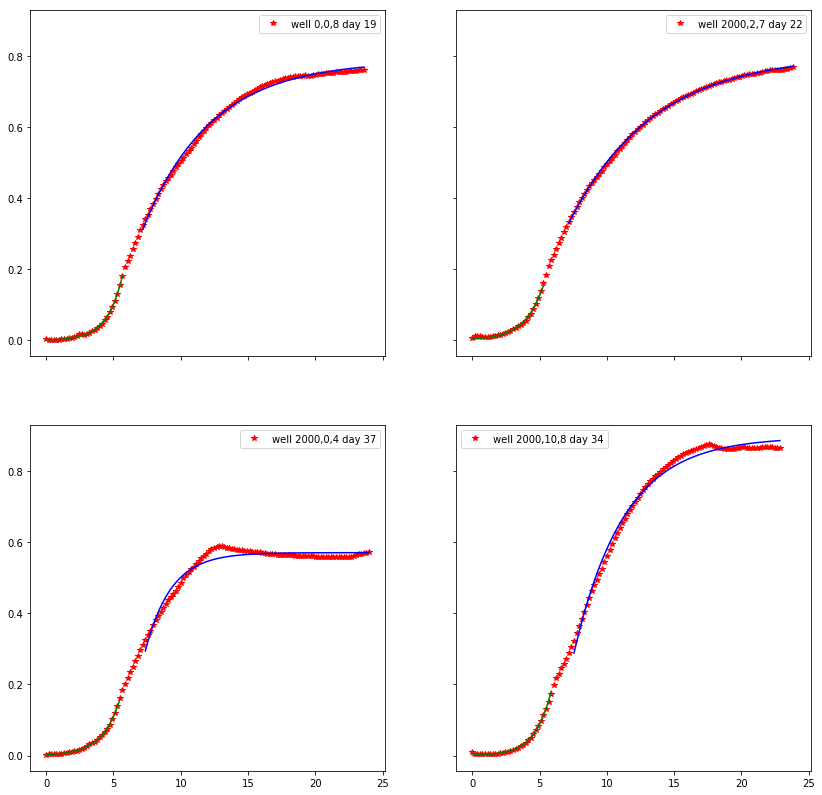

In [13]:
rows = 2
columns = 2
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(14,14))
for i in range(rows):
    for j in range(columns):
        day = np.random.randint(42)
        well = treatments[np.random.randint(45)]
        t = days[day]['times']
        P = days[day]['well_ODs'][well]
        cut_index = np.where(P>.24)[0][0]
        p0 = pexps[well][0][day]
        r = pexps[well][1][day]
        exp_fit = shifted_exp(t[:cut_index+1], p0, r, blank)
        stat_index = np.where(P>.4)[0][0]
        stat_fit = shifted_exp(t[stat_index:], *pstas[well][:,day])
        axes[i,j].plot(t, P-blank, 'r*', label='well ' + well + ' day ' + str(day))
        axes[i,j].plot(t[:cut_index+1], exp_fit-blank, 'g-')
        axes[i,j].plot(t[stat_index:], stat_fit-blank, 'b-')
        axes[i,j].legend()

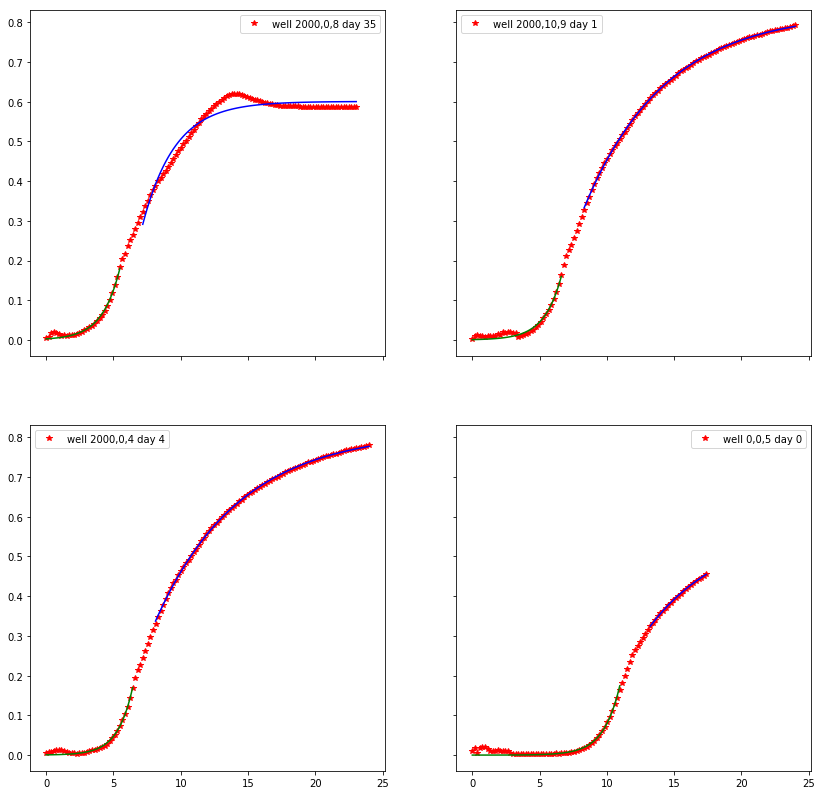

In [14]:
rows = 2
columns = 2
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(14,14))
for i in range(rows):
    for j in range(columns):
        day = np.random.randint(42)
        well = treatments[np.random.randint(45)]
        t = days[day]['times']
        P = days[day]['well_ODs'][well]
        cut_index = np.where(P>.24)[0][0]
        p0 = pexps[well][0][day]
        r = pexps[well][1][day]
        exp_fit = shifted_exp(t[:cut_index+1], p0, r, blank)
        stat_index = np.where(P>.4)[0][0]
        stat_fit = shifted_exp(t[stat_index:], *pstas[well][:,day])
        axes[i,j].plot(t, P-blank, 'r*', label='well ' + well + ' day ' + str(day))
        axes[i,j].plot(t[:cut_index+1], exp_fit-blank, 'g-')
        axes[i,j].plot(t[stat_index:], stat_fit-blank, 'b-')
        axes[i,j].legend()

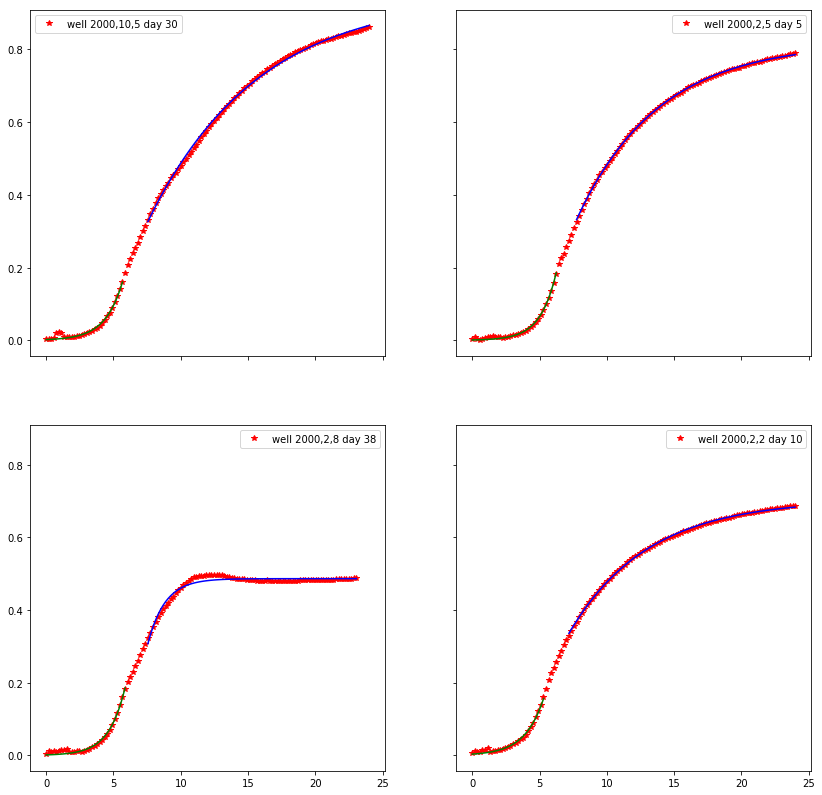

In [15]:
rows = 2
columns = 2
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(14,14))
for i in range(rows):
    for j in range(columns):
        day = np.random.randint(42)
        well = treatments[np.random.randint(45)]
        t = days[day]['times']
        P = days[day]['well_ODs'][well]
        cut_index = np.where(P>.24)[0][0]
        p0 = pexps[well][0][day]
        r = pexps[well][1][day]
        exp_fit = shifted_exp(t[:cut_index+1], p0, r, blank)
        stat_index = np.where(P>.4)[0][0]
        stat_fit = shifted_exp(t[stat_index:], *pstas[well][:,day])
        axes[i,j].plot(t, P-blank, 'r*', label='well ' + well + ' day ' + str(day))
        axes[i,j].plot(t[:cut_index+1], exp_fit-blank, 'g-')
        axes[i,j].plot(t[stat_index:], stat_fit-blank, 'b-')
        axes[i,j].legend()

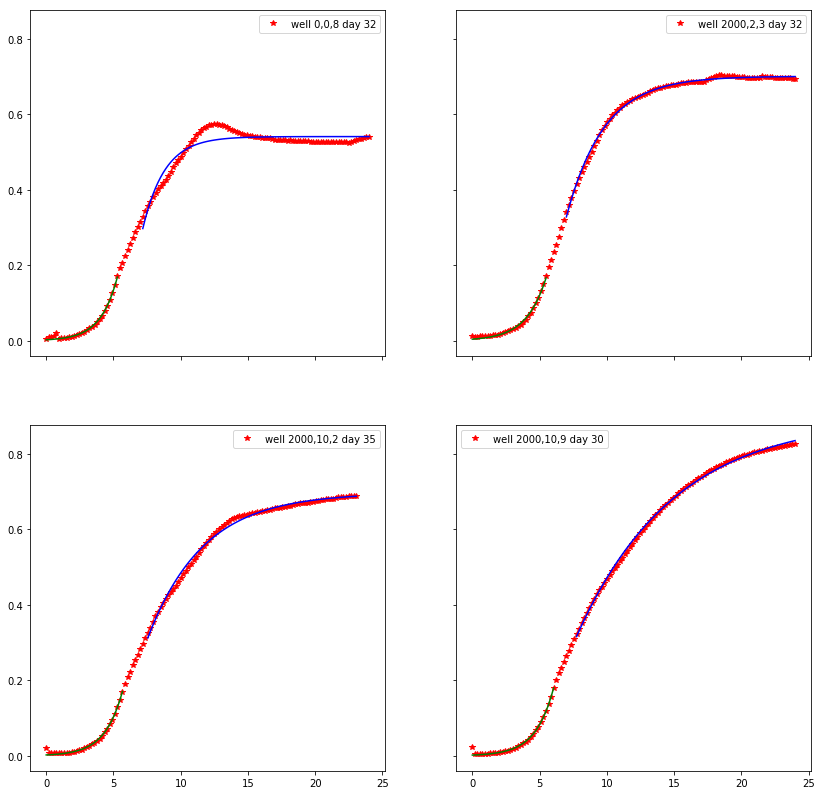

In [16]:
rows = 2
columns = 2
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(14,14))
for i in range(rows):
    for j in range(columns):
        day = np.random.randint(42)
        well = treatments[np.random.randint(45)]
        t = days[day]['times']
        P = days[day]['well_ODs'][well]
        cut_index = np.where(P>.24)[0][0]
        p0 = pexps[well][0][day]
        r = pexps[well][1][day]
        exp_fit = shifted_exp(t[:cut_index+1], p0, r, blank)
        stat_index = np.where(P>.4)[0][0]
        stat_fit = shifted_exp(t[stat_index:], *pstas[well][:,day])
        axes[i,j].plot(t, P-blank, 'r*', label='well ' + well + ' day ' + str(day))
        axes[i,j].plot(t[:cut_index+1], exp_fit-blank, 'g-')
        axes[i,j].plot(t[stat_index:], stat_fit-blank, 'b-')
        axes[i,j].legend()

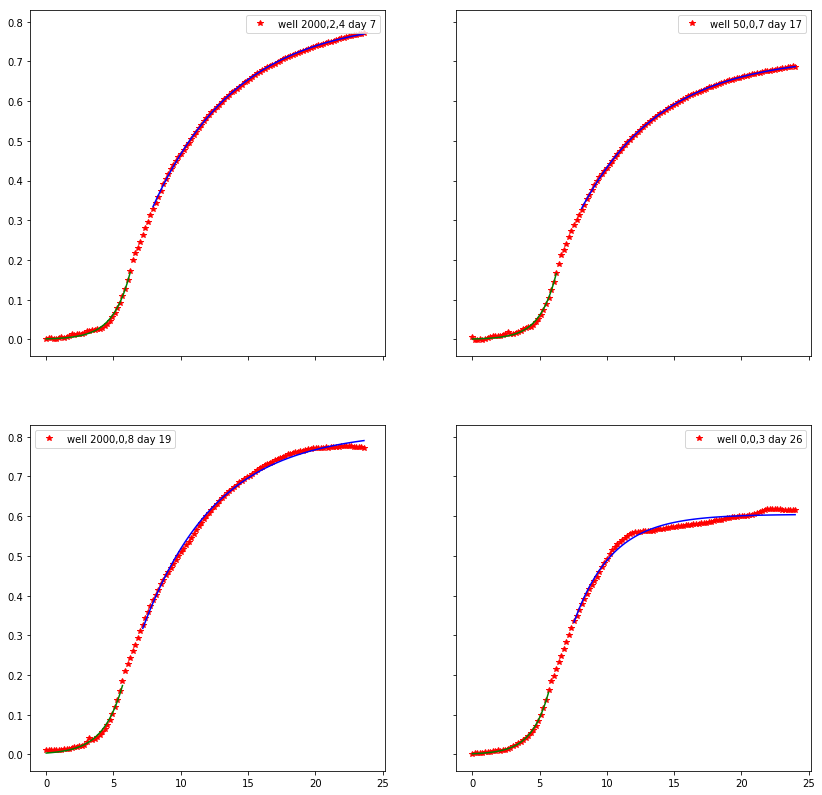

In [17]:
rows = 2
columns = 2
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(14,14))
for i in range(rows):
    for j in range(columns):
        day = np.random.randint(42)
        well = treatments[np.random.randint(45)]
        t = days[day]['times']
        P = days[day]['well_ODs'][well]
        cut_index = np.where(P>.24)[0][0]
        p0 = pexps[well][0][day]
        r = pexps[well][1][day]
        exp_fit = shifted_exp(t[:cut_index+1], p0, r, blank)
        stat_index = np.where(P>.4)[0][0]
        stat_fit = shifted_exp(t[stat_index:], *pstas[well][:,day])
        axes[i,j].plot(t, P-blank, 'r*', label='well ' + well + ' day ' + str(day))
        axes[i,j].plot(t[:cut_index+1], exp_fit-blank, 'g-')
        axes[i,j].plot(t[stat_index:], stat_fit-blank, 'b-')
        axes[i,j].legend()

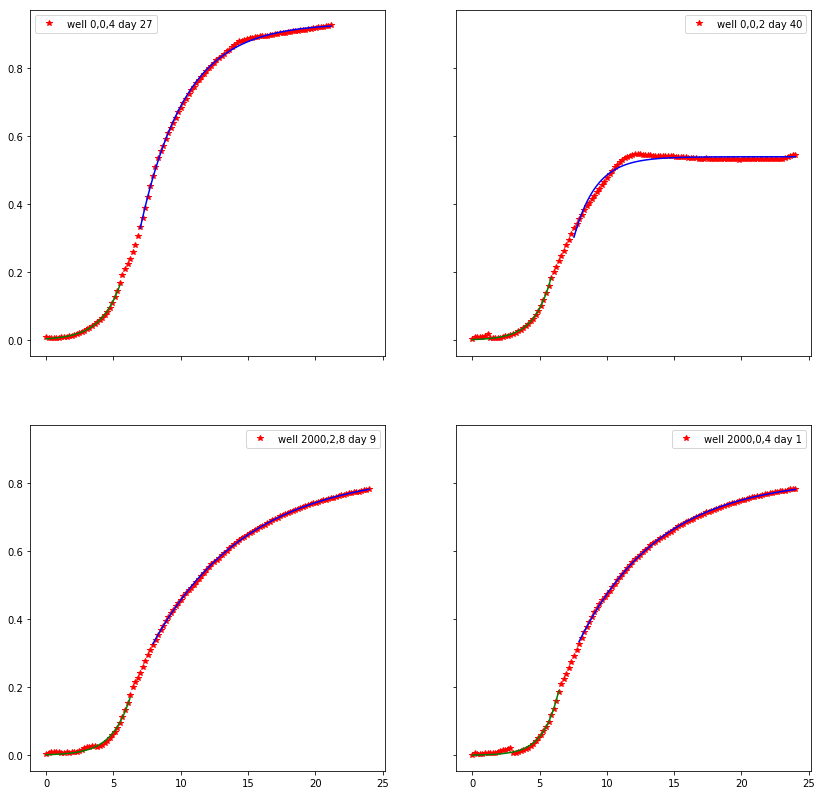

In [18]:
rows = 2
columns = 2
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(14,14))
for i in range(rows):
    for j in range(columns):
        day = np.random.randint(42)
        well = treatments[np.random.randint(45)]
        t = days[day]['times']
        P = days[day]['well_ODs'][well]
        cut_index = np.where(P>.24)[0][0]
        p0 = pexps[well][0][day]
        r = pexps[well][1][day]
        exp_fit = shifted_exp(t[:cut_index+1], p0, r, blank)
        stat_index = np.where(P>.4)[0][0]
        stat_fit = shifted_exp(t[stat_index:], *pstas[well][:,day])
        axes[i,j].plot(t, P-blank, 'r*', label='well ' + well + ' day ' + str(day))
        axes[i,j].plot(t[:cut_index+1], exp_fit-blank, 'g-')
        axes[i,j].plot(t[stat_index:], stat_fit-blank, 'b-')
        axes[i,j].legend()

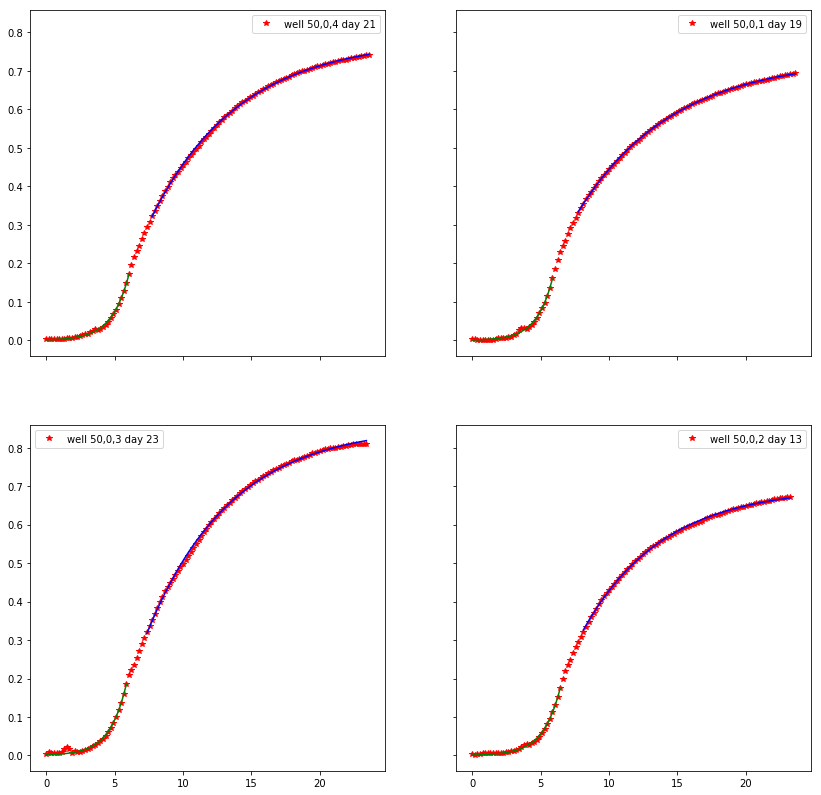

In [19]:
rows = 2
columns = 2
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(14,14))
for i in range(rows):
    for j in range(columns):
        day = np.random.randint(42)
        well = treatments[np.random.randint(45)]
        t = days[day]['times']
        P = days[day]['well_ODs'][well]
        cut_index = np.where(P>.24)[0][0]
        p0 = pexps[well][0][day]
        r = pexps[well][1][day]
        exp_fit = shifted_exp(t[:cut_index+1], p0, r, blank)
        stat_index = np.where(P>.4)[0][0]
        stat_fit = shifted_exp(t[stat_index:], *pstas[well][:,day])
        axes[i,j].plot(t, P-blank, 'r*', label='well ' + well + ' day ' + str(day))
        axes[i,j].plot(t[:cut_index+1], exp_fit-blank, 'g-')
        axes[i,j].plot(t[stat_index:], stat_fit-blank, 'b-')
        axes[i,j].legend()

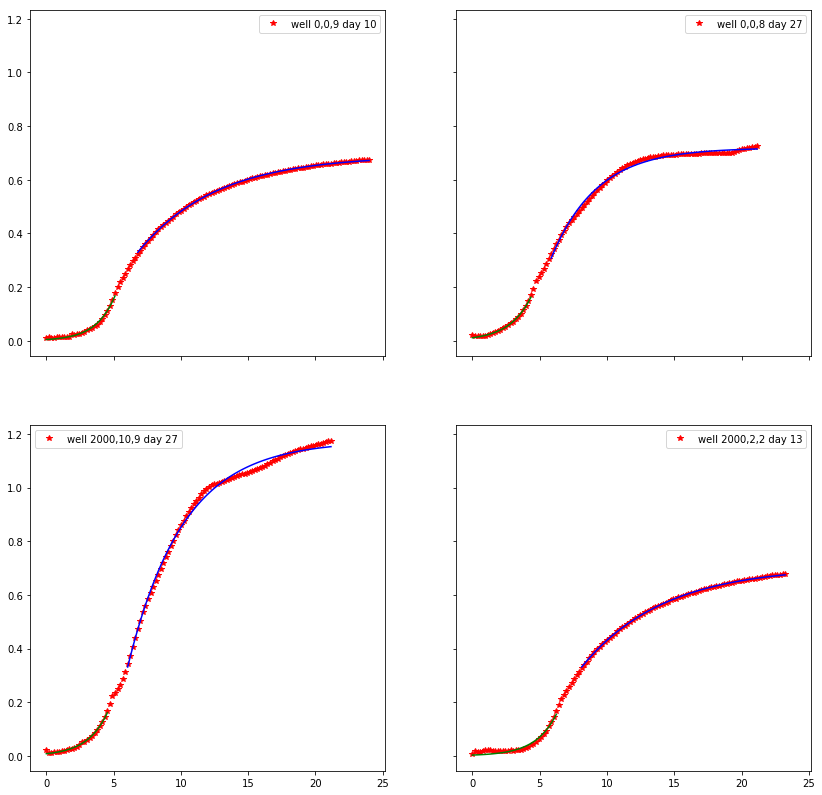

In [20]:
rows = 2
columns = 2
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(14,14))
for i in range(rows):
    for j in range(columns):
        day = np.random.randint(42)
        well = treatments[np.random.randint(45)]
        t = days[day]['times']
        P = days[day]['well_ODs'][well]
        cut_index = np.where(P>.24)[0][0]
        p0 = pexps[well][0][day]
        r = pexps[well][1][day]
        exp_fit = shifted_exp(t[:cut_index+1], p0, r, blank)
        stat_index = np.where(P>.4)[0][0]
        stat_fit = shifted_exp(t[stat_index:], *pstas[well][:,day])
        axes[i,j].plot(t, P-blank, 'r*', label='well ' + well + ' day ' + str(day))
        axes[i,j].plot(t[:cut_index+1], exp_fit-blank, 'g-')
        axes[i,j].plot(t[stat_index:], stat_fit-blank, 'b-')
        axes[i,j].legend()

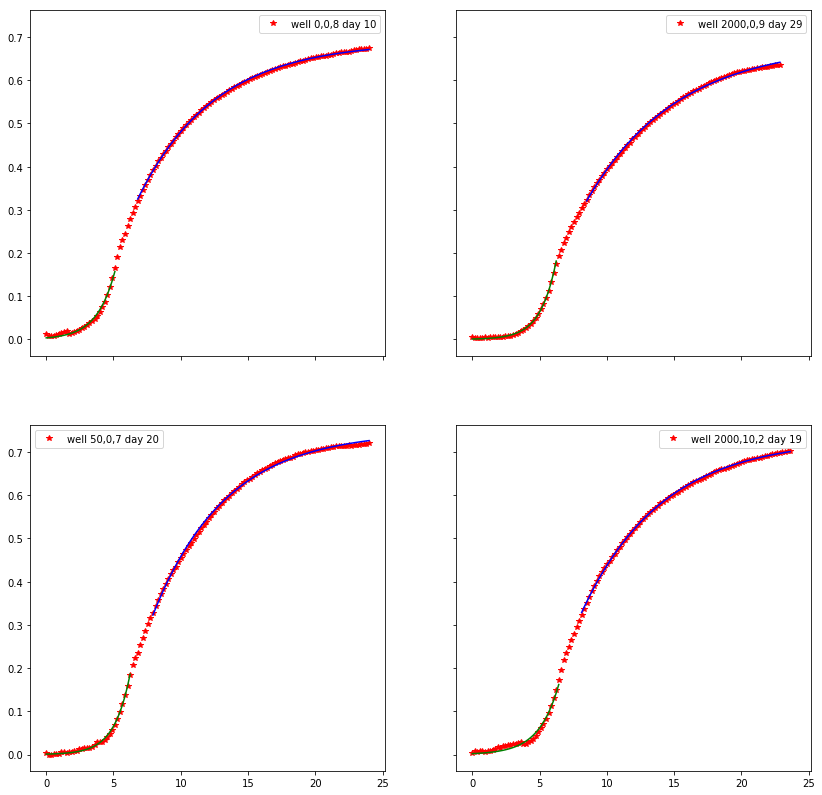

In [21]:
rows = 2
columns = 2
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(14,14))
for i in range(rows):
    for j in range(columns):
        day = np.random.randint(42)
        well = treatments[np.random.randint(45)]
        t = days[day]['times']
        P = days[day]['well_ODs'][well]
        cut_index = np.where(P>.24)[0][0]
        p0 = pexps[well][0][day]
        r = pexps[well][1][day]
        exp_fit = shifted_exp(t[:cut_index+1], p0, r, blank)
        stat_index = np.where(P>.4)[0][0]
        stat_fit = shifted_exp(t[stat_index:], *pstas[well][:,day])
        axes[i,j].plot(t, P-blank, 'r*', label='well ' + well + ' day ' + str(day))
        axes[i,j].plot(t[:cut_index+1], exp_fit-blank, 'g-')
        axes[i,j].plot(t[stat_index:], stat_fit-blank, 'b-')
        axes[i,j].legend()